<h2>Code-Beispiel: Markerbasierte Posenbestimmung</h2>
<font size="3" face="Verdana">
<p style="text-align:justify">Im folgenden befindet sich eine Implementierung der markerbasierten Posenbestimmung. </p>
<p style="text-align:justify">Dazu muss jedoch zuerst in den nachstehenden Code-Block geklickt werden und dieser durch drücken der "Run" Taste in der Leiste oben ausgeführt werden. </p> 
</font>

0) Originalbild


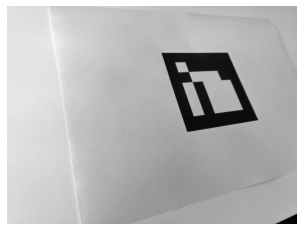

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cv2
import math


#lies Bild als Grauwertbild ein und zeige es an
print("0) Originalbild")
img = cv2.imread('marker_img_k.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()


#1) TODO: Wandle das Bild in ein Binärbild um mit Threshold 127 
#TIP: Größe eines Bildes gegeben über img.shape
#TIP: Ein Pixel im Bild kann geändert werden über img[x,y] = neuer Wert







print("1) Binärbild")
plt.imshow(img_bin, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis("off")
plt.show()


#2) Berechnen der Umrisse
contours = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
print("2) Umrisse")
img_rgb = cv2.cvtColor(img_bin,cv2.COLOR_GRAY2RGB)
for cont in contours:
    cv2.drawContours(img_rgb, cont, -1, (0,255,0), 3)
plt.figure()
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


# Vereinfachen der Umrisse & 3) Finde Markerkandidaten
numVierEcken = 0
kandidaten = []
img_rgb2 = cv2.cvtColor(img_bin,cv2.COLOR_GRAY2RGB)
for cont in contours:
    approx = cv2.approxPolyDP(cont, 1.9, True)
    
    if len(approx) == 4:
        numVierEcken = numVierEcken+1
        kandidaten.append(approx)
        cv2.drawContours(img_rgb2, approx, -1, (0,255,0), 3)
     
print("3) Eckpunkte der vereinfachten Umrisse, welche Markerkandidaten darstellen")
plt.figure()
plt.imshow(img_rgb2)
plt.axis("off")
plt.show()




#4) Muster überprüfen
print("3) Homographie berechnen und auf die Bildbereiche mit potentiellen Markern anwenden:")
musterImg = cv2.imread('marker.png',cv2.IMREAD_GRAYSCALE)
height,width = musterImg.shape[:2]
muster = np.array([[0,0],[height,0],[height,width], [0,width]])
trans_images = []
for kan in kandidaten:
    H = cv2.findHomography(kan, muster)
    rows,cols = img_bin.shape
    dst = cv2.warpPerspective(img_bin, H[0], (width,height))
    trans_images.append(dst)

#Zeige die transformierten Bildausschnitte
for i in trans_images:
    plt.figure()
    plt.imshow(i, cmap='gray')
    plt.axis("off")
    plt.show()


print("4) Kandidaten mit dem original Marker vergleichen:")
#Bitweiser Vergleich zwischen Markerkandidaten und echtem Marker
original_bit_id = []
muster_bin = cv2.threshold(musterImg, threshold, 255, cv2.THRESH_BINARY)[1]
for h in range(height):
    for w in range(width):
        if muster_bin[h][w] == 0:
            original_bit_id.append(0)
        else:
            original_bit_id.append(1)

bit_ids = []
diffs = []
best_diffs = []
d=0
img_nr = 0
for i in trans_images:
    bit_id = []
    i_bin = cv2.threshold(i, threshold, 255, cv2.THRESH_BINARY)[1]
    #Marker Kandidaten ohne Rotation
    for h in range(height):
        for w in range(width):
            if i_bin[h][w] == 0:
                bit_id.append(0)
            else:
                bit_id.append(1)
    bit_ids.append(bit_id)
    diffs.append(0)
    #Vergleich mit Muster
    for j in range(height*width):
        if bit_ids[d][j] != original_bit_id[j]:
            diffs[d] = diffs[d] + 1
    d = d+1
    
    #Marker Kandidaten um 90 Grad rotiert
    bit_id = []
    i_bin = cv2.rotate(i_bin, cv2.ROTATE_90_CLOCKWISE)
    for h in range(height):
        for w in range(width):
            if i_bin[h][w] == 0:
                bit_id.append(0)
            else:
                bit_id.append(1)
    bit_ids.append(bit_id)
    diffs.append(0)
    #Vergleich mit Muster
    for j in range(height*width):
        if bit_ids[d][j] != original_bit_id[j]:
            diffs[d] = diffs[d] + 1
    d = d+1
    
    #Marker Kandidaten um 180 Grad rotiert
    bit_id = []
    i_bin = cv2.rotate(i_bin, cv2.ROTATE_90_CLOCKWISE)
    for h in range(height):
        for w in range(width):
            if i_bin[h][w] == 0:
                bit_id.append(0)
            else:
                bit_id.append(1)
    bit_ids.append(bit_id)
    diffs.append(0)
    #Vergleich mit Muster
    for j in range(height*width):
        if bit_ids[d][j] != original_bit_id[j]:
            diffs[d] = diffs[d] + 1
    d = d+1

    #Marker Kandidaten um 270 Grad rotiert
    bit_id = []
    i_bin = cv2.rotate(i_bin, cv2.ROTATE_90_CLOCKWISE)
    for h in range(height):
        for w in range(width):
            if i_bin[h][w] == 0:
                bit_id.append(0)
            else:
                bit_id.append(1)
    bit_ids.append(bit_id)
    diffs.append(0)
    #Vergleich mit Muster
    for j in range(height*width):
        if bit_ids[d][j] != original_bit_id[j]:
            diffs[d] = diffs[d] + 1
    d = d+1
    
    #Speichere besten diff für alle Marker
    best_diffs.append(diffs[d-4])
    for i in range(1, 3):
        if diffs[d-i] < best_diffs[img_nr]:
            best_diffs[img_nr] = diffs[d-i]

    img_nr = img_nr + 1


print("Prozentualer Unterschied der Bits:")
best = 0
best_diff = 1.0
for i in range(0, len(kandidaten)):
    if (best_diffs[i]/(height*width) < best_diff):
        best_diff = best_diffs[i]/(height*width)
        best = i
    print("Kandidat " + str(i) + ": " + str(best_diffs[i]/(height*width)))



#Kameramatrix
K = np.array([[917, 0, 500], [0, 917, 375], [0, 0, 1]])


#Exkpunkte des Markers
points_2D = kandidaten[best]
points_2D = points_2D[:,0]






#TODO: Pose bestimmen über Homography

#TODO: Eckpunkte des Markers in 3D definieren (links oben, rechts oben, rechts unten, links unten) 
#Markerbreite und Höhe
width = 50
height = 50 


#TODO: z-Werte aus 3D Punkten entfernen


#TODO: Homography zwischen 3D und 2D Punkten berechnen (Funktion: h, status =cv2.findHomography(punkte1, punkte2) kann genutzt werden)


#TODO: Inverse von K mit Homography multiplizieren und als G speichern


#Normalisieren
#TODO: Geometrischer Mittelwert l berechnen durch: G1 und G2 normalisieren, multiplizieren und die Wurzel ziehen 
#TIP: zum normalisieren kann die Funktion np.linalg.norm() verwendet werden, zum Wurzel ziehen math.sqrt()


#TODO: zweite Spalte von G durch norm(G2) teilen -> R2


#TODO: Kreuzprodukt aus R2 und erster Spalte von G bilden und normieren (durch norm von diesem Kreuzprodukt teilen) -> R3


#TODO: Kreuzprodukt aus R2 und R3 bilden ->R1


#TODO: T berechnen, indem G3 durch l geteilt wird


#TODO: RT bilden mit den Spalten R1, R2, R3 und T 


#TODO: P berechnen indem K mit RT multipliziert wird


#berechne Koordinaten eines Koordinatensystems in der Bildebene und zeichne sie ein
#Punkte in 3D definieren
origin_3D = np.array([0, 0, 0, 1])
x_3D = np.array([width/3, 0, 0, 1])
y_3D = np.array([0, width/3, 0, 1])
z_3D = np.array([0, 0,  -width/3, 1])

#TODO: Punkte auf Bild projezieren (origin_2D, x_2D, y_2D, z_2D)


#Originalbild mit Koordinatensystem anzeigen
img_lines=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
cv2.circle(img_lines,(int(origin_2D[0]),int(origin_2D[1])), 30, (255,0,0), -1)
cv2.line(img_lines,(int(origin_2D[0]),int(origin_2D[1])),(int(x_2D[0]),int(x_2D[1])),(0,255,0),5)
cv2.line(img_lines,(int(origin_2D[0]),int(origin_2D[1])),(int(y_2D[0]),int(y_2D[1])),(0,0,255),5)
cv2.line(img_lines,(int(origin_2D[0]),int(origin_2D[1])),(int(z_2D[0]),int(z_2D[1])),(255,255,0),5)
plt.imshow(img_lines)
plt.axis("off")
plt.show()


